In [ ]:
# Install required libraries
!pip install pandas scipy scikit-learn seaborn matplotlib
!pip install tabulate


# Import required libraries
import pandas as pd
from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Upload the .arff file manually
from google.colab import files
uploaded = files.upload()

# Load the .arff file into a DataFrame
data, meta = arff.loadarff('Rice_Cammeo_Osmancik.arff')
df = pd.DataFrame(data)

# Decode byte data in columns
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].str.decode('utf-8')

# Check first few rows of the dataset to confirm successful loading
df.head()


Saving Rice_Cammeo_Osmancik.arff to Rice_Cammeo_Osmancik.arff


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,Cammeo
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,Cammeo
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,Cammeo
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,Cammeo
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,Cammeo


In [ ]:
# Display descriptive statistics as a well-formatted table
print("Descriptive Statistics:")
display(df.describe().style.format("{:.2f}").set_caption("Descriptive Statistics Table").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'), ('text-align', 'center')]}]
))

Descriptive Statistics:


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.00,3810.00,3810.00,3810.00,3810.00,3810.00,3810.00
mean,12667.73,454.24,188.78,86.31,0.89,12952.50,0.66
std,1732.37,35.60,17.45,5.73,0.02,1776.97,0.08
min,7551.00,359.10,145.26,59.53,0.78,7723.00,0.50
25%,11370.50,426.14,174.35,82.73,0.87,11626.25,0.60
50%,12421.50,448.85,185.81,86.43,0.89,12706.50,0.65
75%,13950.00,483.68,203.55,90.14,0.90,14284.00,0.73
max,18913.00,548.45,239.01,107.54,0.95,19099.00,0.86


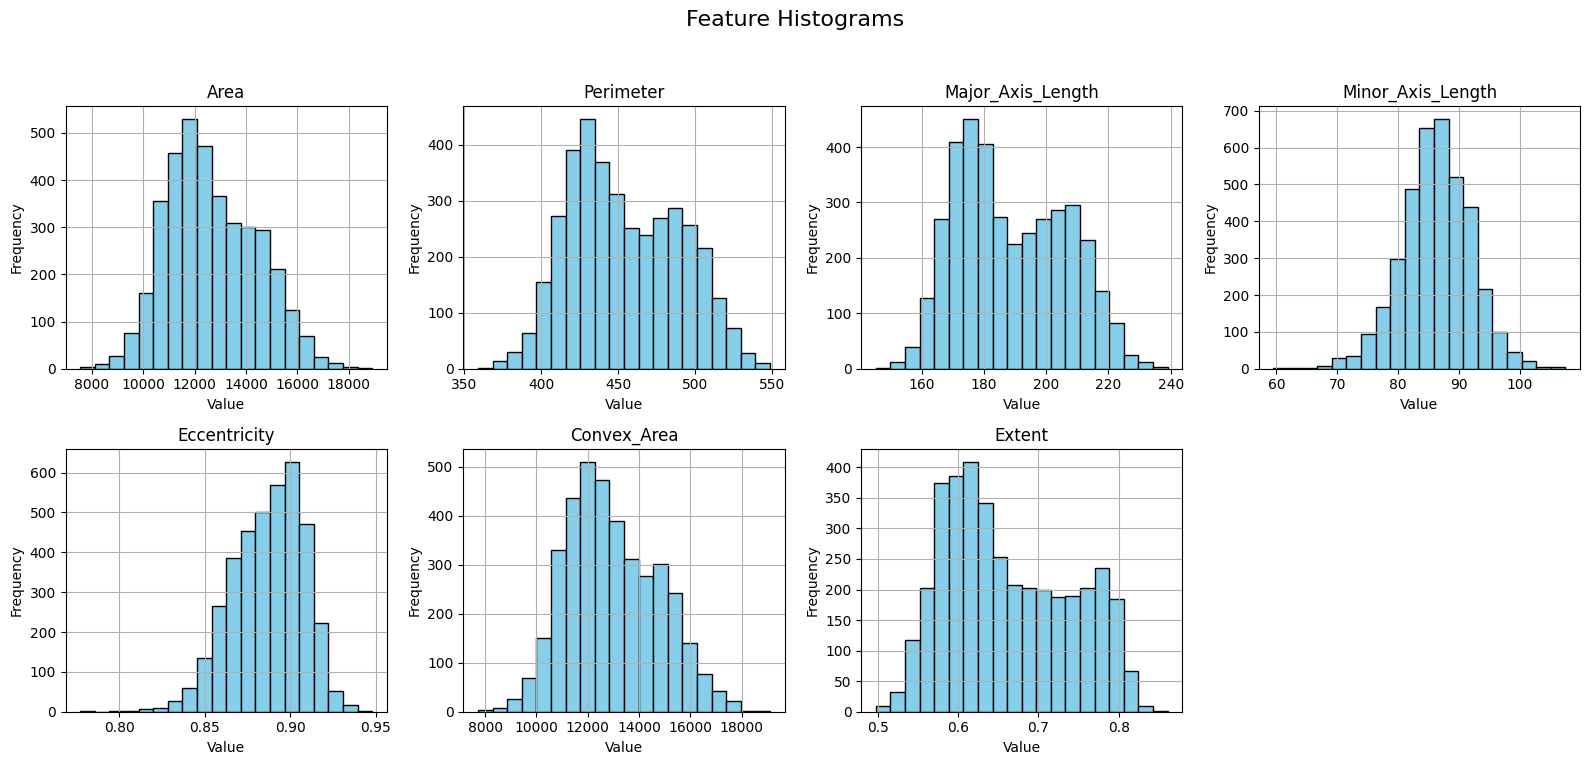

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Feature Histograms", fontsize=16)

# List of features in the dataset
features = df.columns[:-1]

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    row, col = divmod(i, 4)
    df[feature].hist(bins=20, ax=axes[row, col], color='skyblue', edgecolor='black')
    axes[row, col].set_title(feature)
    axes[row, col].set_xlabel("Value")
    axes[row, col].set_ylabel("Frequency")

# Remove any empty subplot if number of features < 8
for j in range(i+1, 8):
    row, col = divmod(j, 4)
    fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

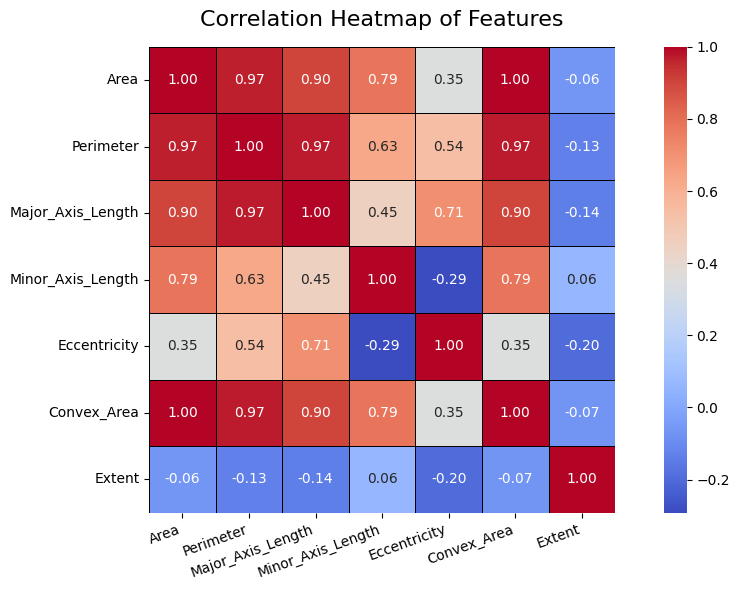

In [ ]:
# Select only numeric columns for the correlation calculation
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 6))

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
            linewidths=0.5, linecolor='black', annot_kws={"size": 10})

# Title
plt.title("Correlation Heatmap of Features", fontsize=16, pad=15)
plt.xticks(rotation=20, fontsize=10, ha='right')
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

plt.show()


Class Balance:
Class
Osmancik    2180
Cammeo      1630


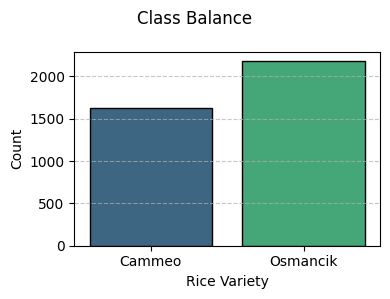

In [ ]:
# Check class balance with clean output
print("Class Balance:")
print(df['Class'].value_counts().to_string(index=True))

# Visualize class balance
plt.figure(figsize=(4, 3))
sns.countplot(data=df, x='Class', palette="viridis", edgecolor='black')

plt.suptitle("Class Balance")
plt.xlabel("Rice Variety", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Area - Skewness: 0.33, Kurtosis: -0.43
Perimeter - Skewness: 0.22, Kurtosis: -0.84
Major_Axis_Length - Skewness: 0.26, Kurtosis: -0.95
Minor_Axis_Length - Skewness: -0.13, Kurtosis: 0.56
Eccentricity - Skewness: -0.45, Kurtosis: 0.07
Convex_Area - Skewness: 0.32, Kurtosis: -0.47
Extent - Skewness: 0.34, Kurtosis: -1.03
Class_numeric - Skewness: -0.29, Kurtosis: -1.91


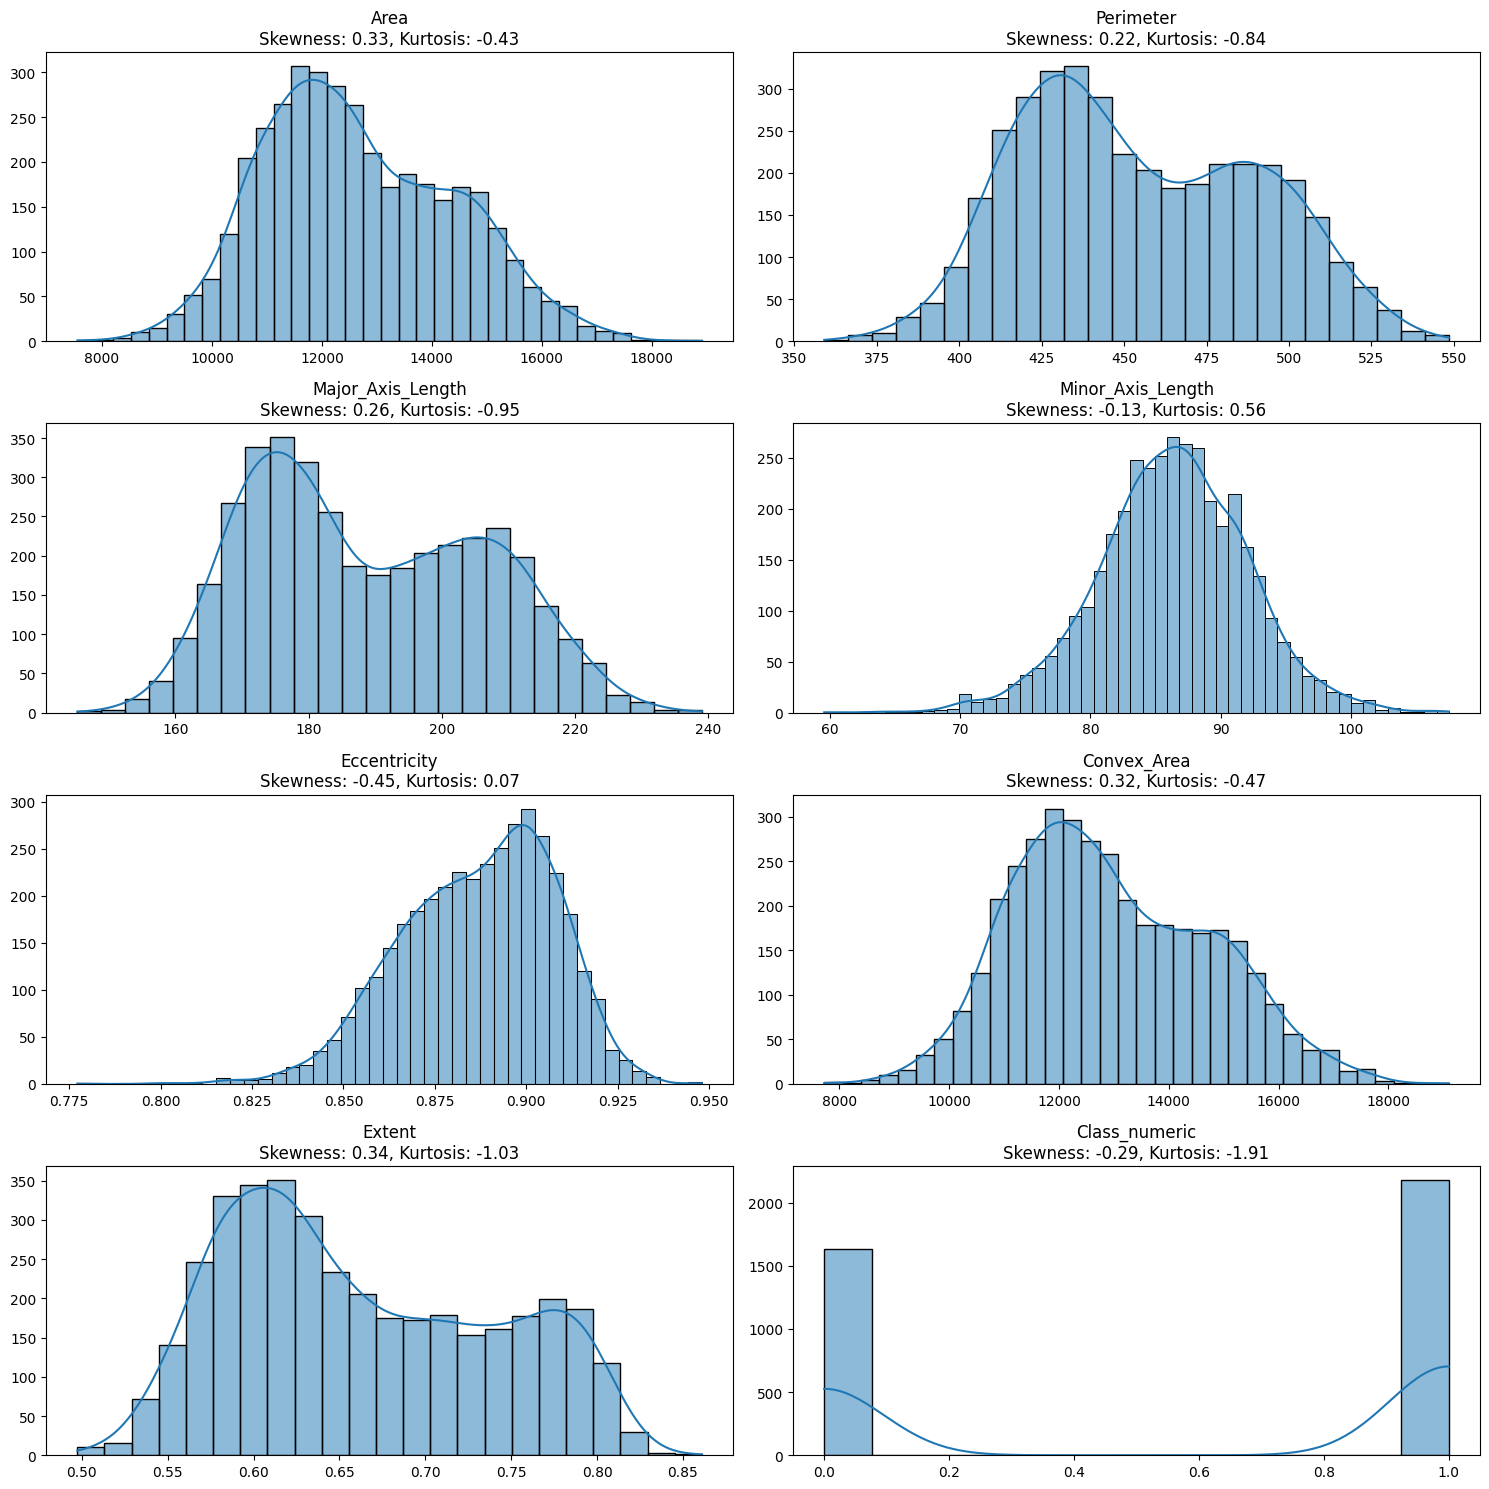

In [ ]:
from scipy.stats import skew, kurtosis

# Get the numerical columns
num_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Create subplots with a grid layout (2 plots per row)
fig, axes = plt.subplots(nrows=len(num_columns) // 2 + len(num_columns) % 2, ncols=2, figsize=(15, 15))
axes = axes.flatten()

# Calculate skewness and kurtosis, and plot each feature
for i, column in enumerate(num_columns):
    skewness = skew(df[column])
    kurt = kurtosis(df[column])
    print(f'{column} - Skewness: {skewness:.2f}, Kurtosis: {kurt:.2f}')

    # Plotting the histogram on a subplot
    sns.histplot(df[column], kde=True, ax=axes[i])
    axes[i].set_title(f'{column}\nSkewness: {skewness:.2f}, Kurtosis: {kurt:.2f}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum().to_dict()

# Display missing values information
print("Missing Values Per Feature:")
for feature, count in missing_values.items():
    print(f"{feature}: {count}")

# Check and display if there are any missing values
total_missing = sum(missing_values.values())
if total_missing == 0:
    print("\nNo missing values detected in the dataset.")
else:
    print(f"\nTotal missing values in dataset: {total_missing}")
    print("Proceeding to drop rows with missing values (if applicable).")

    # Drop rows with missing values
    df = df.dropna()

    # Confirm missing values removal
    print("\nUpdated Missing Values Count After Dropping Rows:")
    updated_missing_values = df.isnull().sum().to_dict()
    for feature, count in updated_missing_values.items():
        print(f"{feature}: {count}")


Missing Values Per Feature:
Area: 0
Perimeter: 0
Major_Axis_Length: 0
Minor_Axis_Length: 0
Eccentricity: 0
Convex_Area: 0
Extent: 0
Class: 0

No missing values detected in the dataset.


In [ ]:
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Apply outlier capping
numeric_features = df.select_dtypes(include=[np.number]).columns
df = cap_outliers(df, numeric_features)

# Confirm changes by rechecking the descriptive stats
df.describe().style.set_caption("Capped Outliers")

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.267454,454.239180,188.776222,86.326474,0.886932,12952.146949,0.661934
std,1730.887966,35.597081,17.448679,5.615361,0.020605,1775.858126,0.077239
min,7551.000000,359.100006,145.264465,71.613723,0.827122,7723.000000,0.497413
25%,11370.500000,426.144753,174.353855,82.731695,0.872402,11626.250000,0.598862
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562
max,17819.250000,548.445984,239.010498,101.261649,0.947868,18270.625000,0.861050


In [ ]:
# Encode target variable
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])

# Display encoded target variable
print("Encoded Target Variable:")
print(df['Class'].unique())  # Shows the unique encoded values
print("Classes:", encoder.classes_)  # Shows the mapping of original class names to encoded values

# Scale numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns  # Identify numeric features
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Display scaled data as a styled table
df.head().style.set_caption("Scaled Data (First 5 Rows)").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'), ('text-align', 'center')]}]
)

Encoded Target Variable:
[0 1]
Classes: ['Cammeo' 'Osmancik']


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,0.747937,0.879232,0.901216,0.454671,0.842763,0.748415,0.207577,0.000000
1,0.691939,0.714095,0.648087,0.678538,0.565512,0.696745,0.324564,0.000000
2,0.689796,0.750066,0.734349,0.544880,0.703927,0.685557,0.538576,0.000000
3,0.547805,0.524136,0.512800,0.534090,0.536160,0.535192,0.393954,0.000000
4,0.695055,0.781992,0.709138,0.596964,0.658980,0.714758,0.408680,0.000000



KNN Performance:
+-----------+----------+
| Metric    |    Score |
+===========+==========+
| Accuracy  | 0.905512 |
+-----------+----------+
| Precision | 0.901734 |
+-----------+----------+
| Recall    | 0.891429 |
+-----------+----------+
| F1 Score  | 0.896552 |
+-----------+----------+

Decision Tree Performance:
+-----------+----------+
| Metric    |    Score |
+===========+==========+
| Accuracy  | 0.877953 |
+-----------+----------+
| Precision | 0.879056 |
+-----------+----------+
| Recall    | 0.851429 |
+-----------+----------+
| F1 Score  | 0.865022 |
+-----------+----------+


<Figure size 1000x500 with 0 Axes>

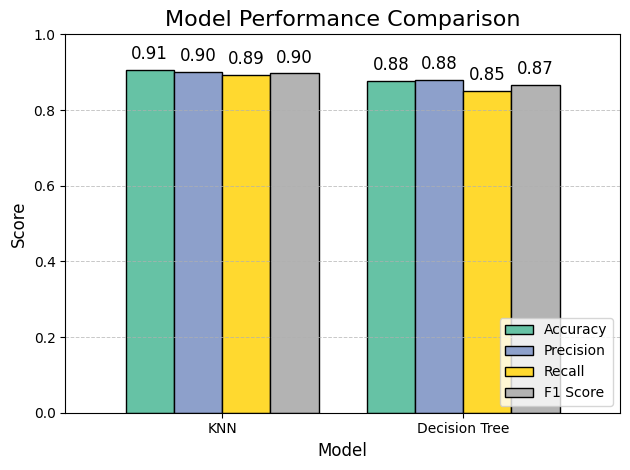

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.io import arff

# Load the .arff file
data, meta = arff.loadarff('/content/Rice_Cammeo_Osmancik.arff')
df = pd.DataFrame(data)

# Convert binary class values to string if needed
df['Class'] = df['Class'].str.decode('utf-8')

# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for both training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

######################################
# K-Nearest Neighbors Classifier
######################################

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)
knn_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn, pos_label="Cammeo"),
    "Recall": recall_score(y_test, y_pred_knn, pos_label="Cammeo"),
    "F1 Score": f1_score(y_test, y_pred_knn, pos_label="Cammeo")
}
print("\nKNN Performance:")
print(tabulate(knn_metrics.items(), headers=["Metric", "Score"], tablefmt="grid"))

######################################
# Decision Tree Classifier
######################################

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
dt_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt, pos_label="Cammeo"),
    "Recall": recall_score(y_test, y_pred_dt, pos_label="Cammeo"),
    "F1 Score": f1_score(y_test, y_pred_dt, pos_label="Cammeo")
}
print("\nDecision Tree Performance:")
print(tabulate(dt_metrics.items(), headers=["Metric", "Score"], tablefmt="grid"))

######################################
# Combine Metrics for KNN and Decision Tree
######################################

metrics_df = pd.DataFrame({
    "KNN": knn_metrics,
    "Decision Tree": dt_metrics
}).T

# Plot metrics for both models
plt.figure(figsize=(10, 5))
ax = metrics_df.plot(kind="bar", rot=0, colormap="Set2", edgecolor="black", width=0.8)

# Adding annotations to show values on bars
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v.get_height():.2f}' for v in container], fontsize=12, padding=5)

plt.title("Model Performance Comparison", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()



Confusion Matrix - K-Nearest Neighbors:
[[312  38]
 [ 34 378]]


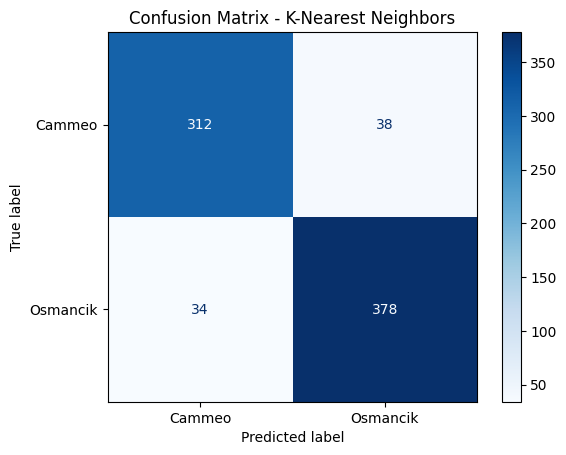


Confusion Matrix - Decision Tree:
[[298  52]
 [ 41 371]]


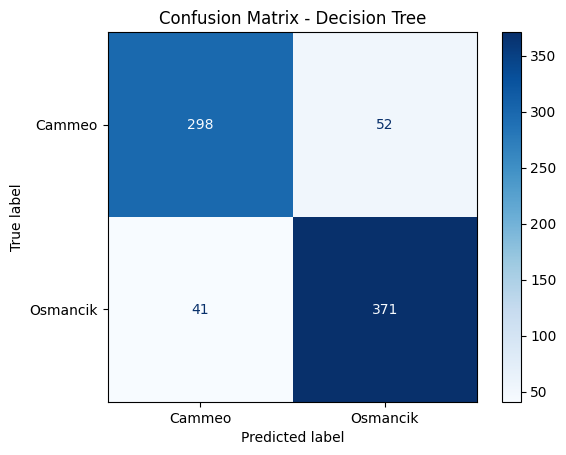

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix for K-Nearest Neighbors
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn, labels=["Cammeo", "Osmancik"])
print("\nConfusion Matrix - K-Nearest Neighbors:")
print(conf_matrix_knn)

# Visualize the confusion matrix for K-Nearest Neighbors
disp_knn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn, display_labels=["Cammeo", "Osmancik"])
disp_knn.plot(cmap="Blues")
plt.title("Confusion Matrix - K-Nearest Neighbors")
plt.show()

# Confusion matrix for Decision Tree
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt, labels=["Cammeo", "Osmancik"])
print("\nConfusion Matrix - Decision Tree:")
print(conf_matrix_dt)

# Visualize the confusion matrix for Decision Tree
disp_dt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt, display_labels=["Cammeo", "Osmancik"])
disp_dt.plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


Class distribution in the full dataset: Class
Osmancik    2180
Cammeo      1630
Name: count, dtype: int64
Class distribution in y_train: Class
Osmancik    1635
Cammeo      1222
Name: count, dtype: int64
Class distribution in y_test: Class
Osmancik    545
Cammeo      408
Name: count, dtype: int64
Class distribution after SMOTE: Class
Cammeo      1635
Osmancik    1635
Name: count, dtype: int64


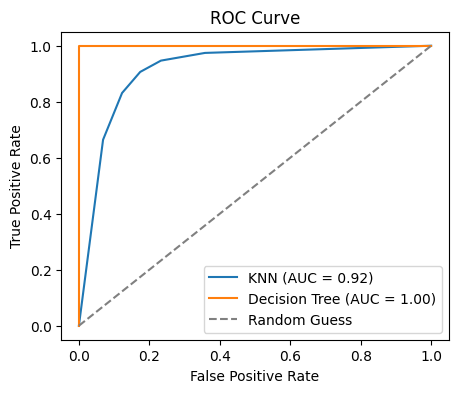

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize, LabelEncoder
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import pandas as pd

X = df.drop('Class', axis=1)  # Features
y = df['Class']  # Target variable

# 1. Check the class distribution in the entire dataset
print(f"Class distribution in the full dataset: {pd.Series(y).value_counts()}")

# 2. Stratified train-test split to ensure both classes are present in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Check class distribution in the stratified train and test sets
print(f"Class distribution in y_train: {pd.Series(y_train).value_counts()}")
print(f"Class distribution in y_test: {pd.Series(y_test).value_counts()}")

# 3. Apply SMOTE if the classes are still imbalanced in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
print(f"Class distribution after SMOTE: {pd.Series(y_train_resampled).value_counts()}")

# 4. Encode the target labels if they are strings (e.g., 'Osmancik' and 'Cammeo')
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test)

# 5. Binarize the target for AUC calculation
y_train_binarized = label_binarize(y_train_encoded, classes=[0, 1])
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1])

# 6. Train and evaluate KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_resampled, y_train_binarized.ravel())  # Use ravel to flatten y_train
y_pred_knn = knn.predict_proba(X_test)[:, 1]  # Get the probability for class 1

# 7. Train and evaluate Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_resampled, y_train_binarized.ravel())
y_pred_dt = dt.predict_proba(X_test)[:, 1]  # Get the probability for class 1

# 8. Calculate ROC Curve and AUC for both models
fpr_knn, tpr_knn, _ = roc_curve(y_test_binarized, y_pred_knn)
fpr_dt, tpr_dt, _ = roc_curve(y_test_binarized, y_pred_dt)

# Calculate AUC
auc_knn = auc(fpr_knn, tpr_knn)
auc_dt = auc(fpr_dt, tpr_dt)

# 9. Plot ROC Curve
plt.figure(figsize=(5, 4))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for KNN
cv_scores_knn = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
print(f'KNN Cross-Validation Accuracy: {cv_scores_knn.mean():.2f} ± {cv_scores_knn.std():.2f}')

# Perform 5-fold cross-validation for Decision Tree
cv_scores_dt = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
print(f'Decision Tree Cross-Validation Accuracy: {cv_scores_dt.mean():.2f} ± {cv_scores_dt.std():.2f}')


KNN Cross-Validation Accuracy: 0.88 ± 0.03
Decision Tree Cross-Validation Accuracy: 1.00 ± 0.00


In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for KNN
knn_params = {'n_neighbors': [3, 5, 7, 9, 11]}

grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
grid_knn.fit(X_train, y_train)
print(f'Best KNN Parameters: {grid_knn.best_params_}')
print(f'Best KNN Score: {grid_knn.best_score_:.2f}')

# Hyperparameter grid for Decision Tree
dt_params = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

grid_dt = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)
print(f'Best Decision Tree Parameters: {grid_dt.best_params_}')
print(f'Best Decision Tree Score: {grid_dt.best_score_:.2f}')


Best KNN Parameters: {'n_neighbors': 5}
Best KNN Score: 0.89
Best Decision Tree Parameters: {'max_depth': None, 'min_samples_split': 2}
Best Decision Tree Score: 1.00
